In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyhrv
import scipy.io as sio
import biosppy
import pyhrv.tools as tools
import matplotlib as mpl
import seaborn as sns


# CinC 2017

## Poincare

In [2]:
labels = ['Normal', 'AF', 'Other', 'Noisy']

In [3]:
data_dir = '/home/huypham/Projects/ecg/dataset/cinc2017/raw/training'

In [4]:
df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_train.csv')

In [5]:
df.head()

,idx,N,A,O,~
0,A06/A06486,1,0,0,0
1,A02/A02603,1,0,0,0
2,A08/A08091,1,0,0,0
3,A05/A05958,1,0,0,0
4,A00/A00988,0,0,0,1


In [6]:
n = df[df['N'] == 1].idx.to_list()
a = df[df['A'] == 1].idx.to_list()
o = df[df['O'] == 1].idx.to_list()
nz = df[df['~'] == 1].idx.to_list()

In [7]:
files = [
    n[1],
    a[1],
    o[0],
    nz[0],
]
files = [os.path.join(data_dir, f'{i}.mat') for i in files]

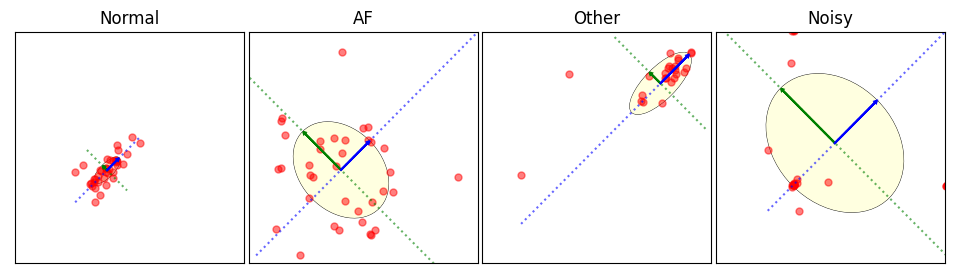

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
# axs = [i for sublist in axs for i in sublist]

for ax, fp, lbl in zip(axs, files, labels):
    ax.set_xlim([100, 400])
    ax.set_ylim([100, 400])
    # ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(lbl)

    data = sio.loadmat(fp)['val'].squeeze()
    data = np.nan_to_num(data)

    _, rpeaks = biosppy.signals.ecg.ecg(data, sampling_rate=300, show=False)[1:3]
    nni = tools.nn_intervals(rpeaks)
    
    nn = pyhrv.utils.check_input(nni, rpeaks)

    # Prepare Poincaré data
    x1 = np.asarray(nn[:-1])
    x2 = np.asarray(nn[1:])

    # SD1 & SD2 Computation
    sd1 = np.std(np.subtract(x1, x2) / np.sqrt(2))
    sd2 = np.std(np.add(x1, x2) / np.sqrt(2))

    # Area of ellipse
    area = np.pi * sd1 * sd2

    nn_mean = np.mean(nn)

    # Ellipse
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2, sd2 * 2, angle=-45, fc='k', zorder=1)
    ax.add_artist(ellipse_)
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2 - 1, sd2 * 2 - 1, angle=-45, fc='lightyellow', zorder=1)
    ax.add_artist(ellipse_)

    # Arrow
    arrow_head_size = 3
    na = 4
    a1 = ax.arrow(
        nn_mean, nn_mean, (-sd1 + na) * np.cos(np.deg2rad(45)), (sd1 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='g', ec='g', zorder=4, linewidth=1.5)
    a2 = ax.arrow(
        nn_mean, nn_mean, (sd2 - na) * np.cos(np.deg2rad(45)), (sd2 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='b', ec='b', zorder=4, linewidth=1.5)
    a3 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    a4 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    ax.add_line(mpl.lines.Line2D(
        (min(nn), max(nn)),
        (min(nn), max(nn)),
        c='b', ls=':', alpha=0.6))
    ax.add_line(mpl.lines.Line2D(
        (nn_mean - sd1 * np.cos(np.deg2rad(45)) * na, nn_mean + sd1 * np.cos(np.deg2rad(45)) * na),
        (nn_mean + sd1 * np.sin(np.deg2rad(45)) * na, nn_mean - sd1 * np.sin(np.deg2rad(45)) * na),
        c='g', ls=':', alpha=0.6))

    # ax.plot(x1, x2, markersize=2)
    ax.plot(x1, x2, 'r%s' % 'o', markersize=5, alpha=0.5, zorder=1)

plt.subplots_adjust(
    left=None, 
    bottom=None, 
    right=None, 
    top=None, 
    wspace=0.02, 
    hspace=0.02,
)
plt.savefig('cinc2017_classes.png', bbox_inches='tight')

## Labels distribution

In [50]:
train_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_train.csv')
val_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_val.csv')
test_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_test.csv')

In [51]:
df_1 = train_df.drop(columns=['idx']).sum()
df_2 = val_df.drop(columns=['idx']).sum()
df_3 = test_df.drop(columns=['idx']).sum()

In [52]:
classes_2017 = pd.concat([df_1, df_2, df_3], axis=1)
classes_2017.columns = ['Train', 'Validation', 'Test']
classes_2017.index = labels
# classes_2017 = classes_2017.divide(classes_2017.sum(axis=0), axis=1) * 100
classes_2017['Total'] = classes_2017.Train + classes_2017.Validation + classes_2017.Test
classes_2017['Total'] = classes_2017['Total'] / classes_2017['Total'].sum() * 100
classes_2017 = classes_2017.reset_index()
classes_2017

,index,Train,Validation,Test,Total
0,Normal,3035,997,1044,59.521576
1,AF,466,152,140,8.888368
2,Other,1452,490,473,28.318480
3,Noisy,163,67,49,3.271576


In [18]:
# df = pd.melt(classes_2017, id_vars=['index'])
# df

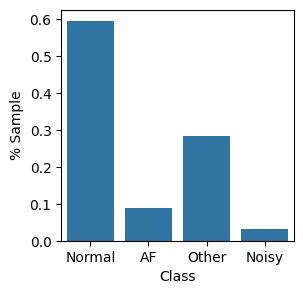

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
ax = sns.barplot(data=classes_2017, x='index', y='Total', color='C0')
# ax.set_axis_labels(x_var="Class", y_var="% Samples")
ax.set_xlabel('Class')
ax.set_ylabel('% Sample')
plt.savefig('cinc2017_classes_dist.pdf', bbox_inches='tight')

In [32]:
# # sns.barplot(data=df, x='variable', y='value', hue='index', palette="muted", facet_kws=dict(margin_titles=True))
# g = sns.FacetGrid(df, col='variable')
# g.map_dataframe(sns.barplot, x='index', y='value')
# g.set_titles("{col_name}")
# g.set_axis_labels(x_var="Class", y_var="% Samples")
# g.savefig('cinc2017_classes_dist.pdf')

# CinC 2020

In [78]:
import sys
sys.path.append('..')
# from preprocess.cinc2020 import load_mat, load_header_file

def load_mat(fp):
    sample = sio.loadmat(fp)['val']
    return sample

def load_header_file(header_file):
    with open(header_file, 'r') as f:
        header = f.readlines()
    header = [line.strip('\n') for line in header]
    return header

In [79]:
classes = "AF,AFL,Brady,CRBBB,IAVB,IRBBB,LAD,LAnFB,LBBB,LPR,LQRSV,LQT,NSIVCB,Other,PAC,PR,PVC,QAb,RAD,RBBB,SA,SB,SNR,STach,SVPB,TAb,TInv,VPB".split(',')
len(classes)

28

In [80]:
data_dir = "/home/huypham/Projects/ecg/dataset/cinc2020/raw/"

In [81]:
df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_train.csv')

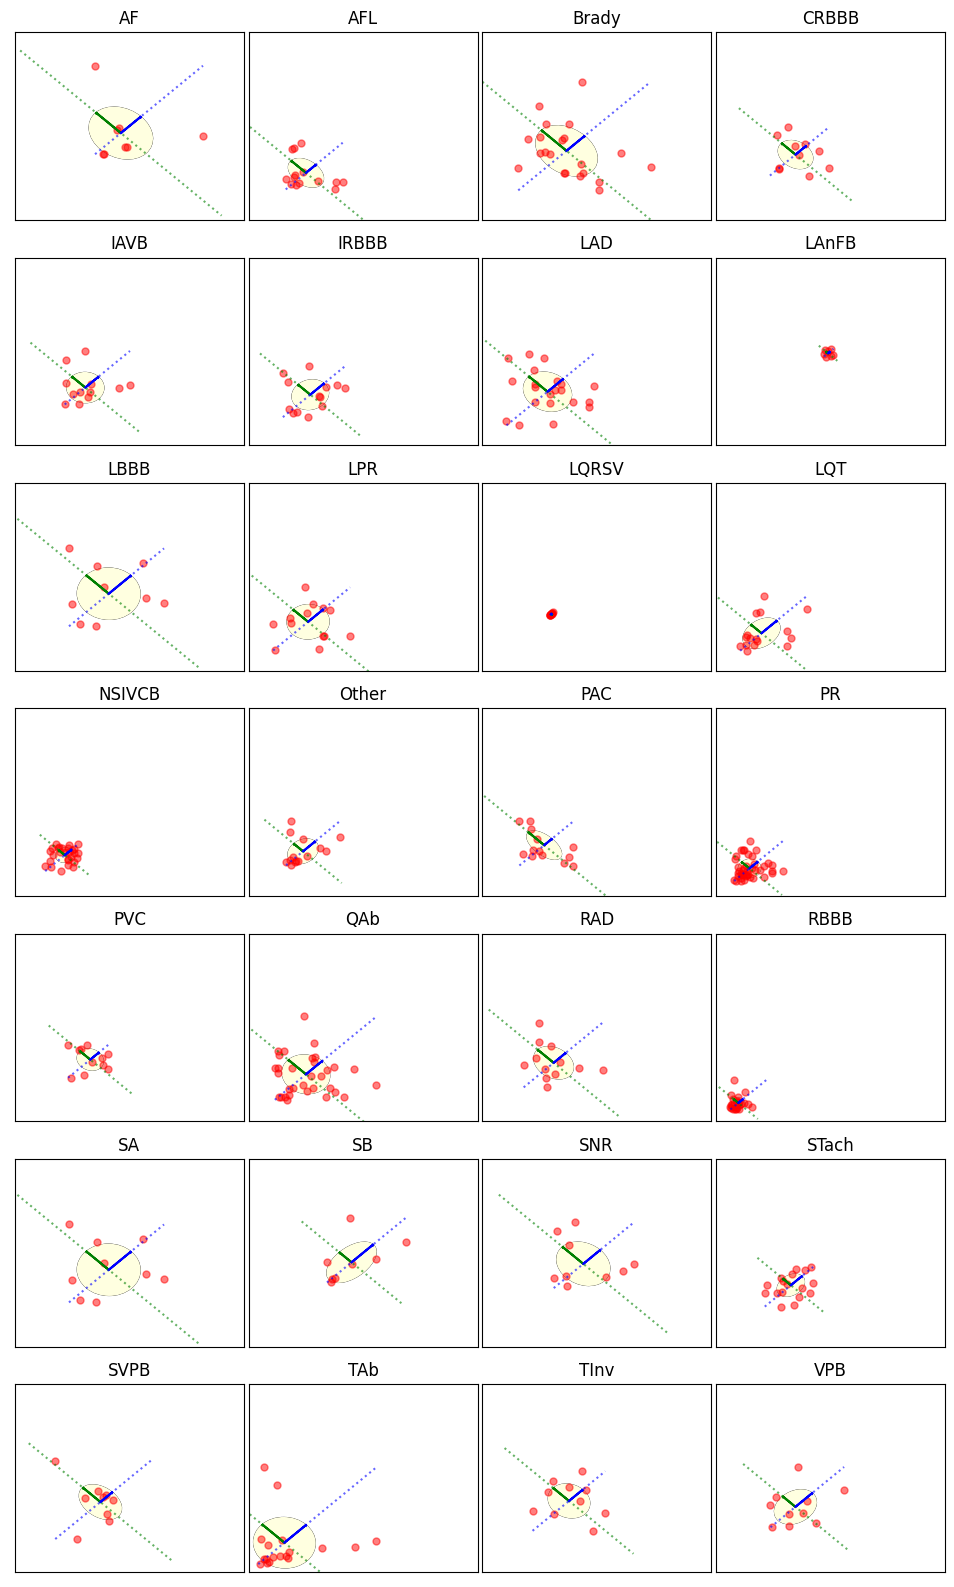

In [85]:
fig, axs = plt.subplots(7, 4, figsize=(12, 20))
axs = [i for sublist in axs for i in sublist]
for lbl, ax in zip(classes, axs):
    fp = df[df['AF'] == 1].idx.sample(n=1).tolist()[0]
    fp = os.path.join(data_dir, fp)

    header_file = fp.replace('.mat', '.hea')
    mat_file = fp.replace('.hea', '.mat')

    sample = load_mat(mat_file)[0].flatten()
    headers = load_header_file(header_file)
    sampling_rate = int(headers[0].split(' ')[2])

    ax.set_xlim([100, 900])
    ax.set_ylim([100, 900])
    # ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(lbl)

    _, rpeaks = biosppy.signals.ecg.ecg(sample, sampling_rate=sampling_rate, show=False)[1:3]
    nni = tools.nn_intervals(rpeaks)
    
    nn = pyhrv.utils.check_input(nni, rpeaks)

    # Prepare Poincaré data
    x1 = np.asarray(nn[:-1])
    x2 = np.asarray(nn[1:])

    # SD1 & SD2 Computation
    sd1 = np.std(np.subtract(x1, x2) / np.sqrt(2))
    sd2 = np.std(np.add(x1, x2) / np.sqrt(2))

    # Area of ellipse
    area = np.pi * sd1 * sd2

    nn_mean = np.mean(nn)

    # Ellipse
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2, sd2 * 2, angle=-45, fc='k', zorder=1)
    ax.add_artist(ellipse_)
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2 - 1, sd2 * 2 - 1, angle=-45, fc='lightyellow', zorder=1)
    ax.add_artist(ellipse_)

    # Arrow
    arrow_head_size = 3
    na = 4
    a1 = ax.arrow(
        nn_mean, nn_mean, (-sd1 + na) * np.cos(np.deg2rad(45)), (sd1 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='g', ec='g', zorder=4, linewidth=1.5)
    a2 = ax.arrow(
        nn_mean, nn_mean, (sd2 - na) * np.cos(np.deg2rad(45)), (sd2 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='b', ec='b', zorder=4, linewidth=1.5)
    a3 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    a4 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    ax.add_line(mpl.lines.Line2D(
        (min(nn), max(nn)),
        (min(nn), max(nn)),
        c='b', ls=':', alpha=0.6))
    ax.add_line(mpl.lines.Line2D(
        (nn_mean - sd1 * np.cos(np.deg2rad(45)) * na, nn_mean + sd1 * np.cos(np.deg2rad(45)) * na),
        (nn_mean + sd1 * np.sin(np.deg2rad(45)) * na, nn_mean - sd1 * np.sin(np.deg2rad(45)) * na),
        c='g', ls=':', alpha=0.6))

    # ax.plot(x1, x2, markersize=2)
    ax.plot(x1, x2, 'r%s' % 'o', markersize=5, alpha=0.5, zorder=1)

# plt.subplots_adjust(
#     left=None, 
#     bottom=None, 
#     right=None, 
#     top=None, 
#     wspace=0.02, 
#     hspace=0.2,
# )

plt.savefig('cinc2020_classes.png', bbox_inches='tight')

In [29]:
train_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_train.csv')
val_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_val.csv')
test_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_test.csv')

In [30]:
df_1 = train_df.drop(columns=['idx']).sum()
df_2 = val_df.drop(columns=['idx']).sum()
df_3 = test_df.drop(columns=['idx']).sum()

In [39]:
classes_2020 = pd.concat([df_1, df_2, df_3], axis=1)
classes_2020.columns = ['Train', 'Validation', 'Test']

classes_2020['Total'] = classes_2020.Train + classes_2020.Validation + classes_2020.Test
classes_2020['Total'] = classes_2020['Total'] / classes_2020['Total'].sum()
classes_2020.index = classes
classes_2020 = classes_2020.divide(classes_2020.sum(axis=0), axis=1) * 100
classes_2020 = classes_2020.reset_index()
classes_2020

,index,Train,Validation,Test,Total
0,AF,4.160645,4.364128,4.431741,4.255189
1,AFL,0.403037,0.307333,0.405680,0.384498
2,Brady,0.366397,0.307333,0.356506,0.352660
3,CRBBB,0.834572,0.842092,0.835946,0.836344
4,IAVB,2.961711,2.821317,2.950396,2.931488
5,IRBBB,2.009079,2.028398,1.807118,1.972693
6,LAD,7.439901,7.468191,7.474338,7.452397
7,LAnFB,2.249272,2.206651,2.102157,2.211474
8,LBBB,1.302746,1.272358,1.192452,1.274720
9,LPR,0.433570,0.399533,0.381093,0.416335


In [34]:
# df = pd.melt(classes_2020, id_vars=['index'])
# df

In [35]:
# # sns.barplot(data=df, x='variable', y='value', hue='index', palette="muted", facet_kws=dict(margin_titles=True))
# g = sns.FacetGrid(df, col='variable', col_wrap=1, aspect=4, height=2)
# g.map_dataframe(sns.barplot, x='index', y='value')
# g.set_titles("{col_name}")
# g.set_axis_labels(x_var="", y_var="% Samples")
# # g.set_xticklabels(rotation=30)
# plt.xticks(rotation=45);
# g.savefig('cinc2020_classes_dist.pdf')

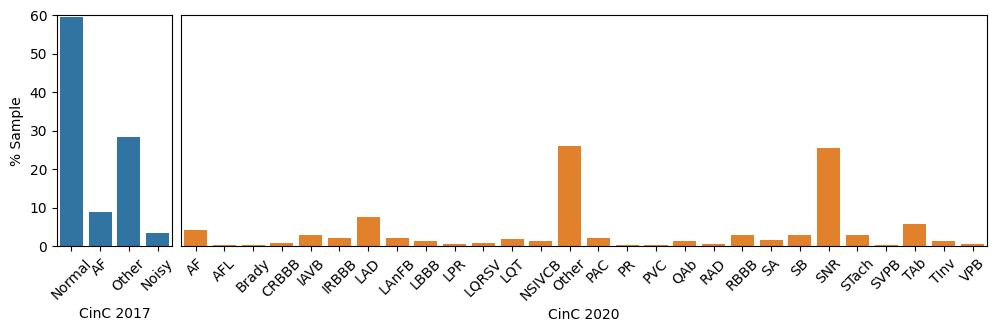

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3), width_ratios=[1, 7])

# CinC2017

ax = sns.barplot(data=classes_2017, x='index', y='Total', color='C0', ax=axs[0])
# ax.set_axis_labels(x_var="Class", y_var="% Samples")
ax.set_xlabel('CinC 2017')
ax.set_ylabel('% Sample')
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(0, 60)
# plt.savefig('cinc2017_classes_dist.pdf', bbox_inches='tight')

# CinC2020

ax = sns.barplot(data=classes_2020, x='index', y='Total', color='C1', ax=axs[1])
# ax.yaxis.tick_right()
# ax.set_axis_labels(x_var="Class", y_var="% Samples")
ax.set_xlabel('CinC 2020')
ax.set_ylabel('')
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(0, 60)
ax.set_yticklabels([])
ax.tick_params(left=False)
# plt.savefig('cinc2017_classes_dist.pdf', bbox_inches='tight')

# axs[1].autoscale() ## call autoscale if needed

plt.subplots_adjust(
    left=None, 
    bottom=None, 
    right=None, 
    top=None, 
    wspace=0.02, 
    hspace=0.05,
)

plt.savefig('classes_distribution.pdf', bbox_inches='tight')